### Test of regularization with error network

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.core import Lambda
from keras.initializers import Constant
from keras.regularizers import l1, l2
from keras.datasets import mnist
from experiment_constant import *
from functools import partial

Using TensorFlow backend.


In [2]:
def get_kernel_reg(layer, errors, is_last, C, p, KLips = 1., lambda_ = 0.1):
    """ Get a DeltaNetwork regularizer for layer"""

    def kernel_reg(w, layer = layer, is_last = is_last, C_layer = C, p_layer = p, KLips = KLips, lambda_ = lambda_):
        """ Regularizer for a layer """
        # Maximal 1-norm over output neuron
        if layer == 0: return 0
        W = K.abs(w)

        print("Error is_last = %d %d = W(pC + K(1-p) DeltaOld) p = %f C = %s K = %f DeltaOld = %s W = %s" % (is_last, layer, p_layer, str(C_layer), KLips, str(errors[layer - 1]), str(W)))
        
        # error (induction)
        error = K.dot(K.transpose(W), p_layer * C_layer + KLips * (1 - p_layer) * errors[layer - 1])
        
        # saving the error for the next call
        errors[layer] = error

        # returning the error scaled
        return K.mean(error) * lambda_ if is_last else 0

    # returning the function
    return kernel_reg

In [3]:
# preparing dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28 ** 2)
x_test = x_test.reshape(-1, 28 ** 2)
digits = {x: [1 if y == x else 0 for y in range(10)] for x in range(10)}
y_train = np.array([digits[y] for y in y_train])
y_test = np.array([digits[y] for y in y_test])

In [4]:
# max per layer variable
C1 = K.variable(value = np.zeros((11, 1)))
C2 = K.variable(value = np.zeros((12, 1)))
C3 = K.variable(value = np.zeros((13, 1)))
C = [C1, C2, C3]

In [5]:
# first layer of error network
errors = {0: K.variable(value = np.zeros((11, 1)))}

In [6]:
# defining the network
model = Sequential()
model.add(Dense(11, kernel_initializer = 'random_normal', bias_initializer = 'random_normal', activation = lambda x : K.relu(1.11 * x), input_shape = (784,)))
model.add(Dense(12, kernel_initializer = 'random_normal', bias_initializer = 'random_normal', activation = lambda x : K.relu(1.11 * x), kernel_regularizer = get_kernel_reg(1, errors, False, C1, 0.1, 1.11, 0)))
model.add(Dense(13, kernel_initializer = 'random_normal', bias_initializer = 'random_normal', activation = lambda x : K.relu(1.11 * x), kernel_regularizer = get_kernel_reg(2, errors, False, C2, 0.2, 1.11, 0)))
model.add(Dense(10, kernel_initializer = 'random_normal', bias_initializer = 'random_normal', activation = 'linear', kernel_regularizer = get_kernel_reg(3, errors, True, C3, 0.3, 1.11, 0.01)))

Error is_last = 0 1 = W(pC + K(1-p) DeltaOld) p = 0.100000 C = <tf.Variable 'Variable:0' shape=(11, 1) dtype=float32_ref> K = 1.110000 DeltaOld = <tf.Variable 'Variable_3:0' shape=(11, 1) dtype=float32_ref> W = Tensor("dense_2/weight_regularizer/Abs:0", shape=(11, 12), dtype=float32)
Error is_last = 0 2 = W(pC + K(1-p) DeltaOld) p = 0.200000 C = <tf.Variable 'Variable_1:0' shape=(12, 1) dtype=float32_ref> K = 1.110000 DeltaOld = Tensor("dense_2/weight_regularizer/MatMul:0", shape=(12, 1), dtype=float32) W = Tensor("dense_3/weight_regularizer/Abs:0", shape=(12, 13), dtype=float32)
Error is_last = 1 3 = W(pC + K(1-p) DeltaOld) p = 0.300000 C = <tf.Variable 'Variable_2:0' shape=(13, 1) dtype=float32_ref> K = 1.110000 DeltaOld = Tensor("dense_3/weight_regularizer/MatMul:0", shape=(13, 1), dtype=float32) W = Tensor("dense_4/weight_regularizer/Abs:0", shape=(13, 10), dtype=float32)


In [7]:
# calculating mean per neuron bound
inp = model.input
outputs = [K.mean(K.abs(layer.output), axis = 0) for layer in model.layers]
mean_per_neuron = lambda x : (K.function([inp, K.learning_phase()], outputs))([x, 1])

In [8]:
# calculating delta network output
delta_network = lambda : (K.function([K.learning_phase()], [K.mean(errors[3])]))([1])[0]

In [9]:
# compiling the model
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy', 'mean_squared_error'])

In [10]:
# training the model
history = []
deltas = []
for i in range(100):
    history += [model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1, batch_size = 30000)]
    for C_, v in zip(C, mean_per_neuron(x_train)):
        K.set_value(C_, v.reshape(-1, 1))
    deltas += [delta_network()]

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 7us/step - loss: 0.1828 - acc: 0.1079 - mean_squared_error: 0.1828 - val_loss: 0.1260 - val_acc: 0.1103 - val_mean_squared_error: 0.1260
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.1291 - acc: 0.1190 - mean_squared_error: 0.1222 - val_loss: 0.1198 - val_acc: 0.1248 - val_mean_squared_error: 0.1132
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.1179 - acc: 0.1359 - mean_squared_error: 0.1114 - val_loss: 0.1126 - val_acc: 0.1469 - val_mean_squared_error: 0.1063
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.1116 - acc: 0.1552 - mean_squared_error: 0.1052 - val_loss: 0.1078 - val_acc: 0.1691 - val_mean_squared_error: 0.1015
Train on 600

60000/60000 [==============================] - 0s 2us/step - loss: 0.0788 - acc: 0.4315 - mean_squared_error: 0.0737 - val_loss: 0.0786 - val_acc: 0.4270 - val_mean_squared_error: 0.0735
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0784 - acc: 0.4344 - mean_squared_error: 0.0733 - val_loss: 0.0782 - val_acc: 0.4315 - val_mean_squared_error: 0.0731
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0781 - acc: 0.4373 - mean_squared_error: 0.0729 - val_loss: 0.0780 - val_acc: 0.4393 - val_mean_squared_error: 0.0728
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0777 - acc: 0.4429 - mean_squared_error: 0.0725 - val_loss: 0.0774 - val_acc: 0.4486 - val_mean_squared_error: 0.0722
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 

60000/60000 [==============================] - 0s 2us/step - loss: 0.0644 - acc: 0.6076 - mean_squared_error: 0.0589 - val_loss: 0.0631 - val_acc: 0.6452 - val_mean_squared_error: 0.0577
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0634 - acc: 0.6250 - mean_squared_error: 0.0579 - val_loss: 0.0624 - val_acc: 0.6525 - val_mean_squared_error: 0.0569
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0628 - acc: 0.6292 - mean_squared_error: 0.0573 - val_loss: 0.0618 - val_acc: 0.6574 - val_mean_squared_error: 0.0563
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0622 - acc: 0.6353 - mean_squared_error: 0.0566 - val_loss: 0.0610 - val_acc: 0.6573 - val_mean_squared_error: 0.0554
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 

60000/60000 [==============================] - 0s 2us/step - loss: 0.0543 - acc: 0.6413 - mean_squared_error: 0.0494 - val_loss: 0.0568 - val_acc: 0.6095 - val_mean_squared_error: 0.0519


In [11]:
# obtaining accuracy
acc = [x for h in history for x in h.history['acc']]
val_acc = [x for h in history for x in h.history['val_acc']]

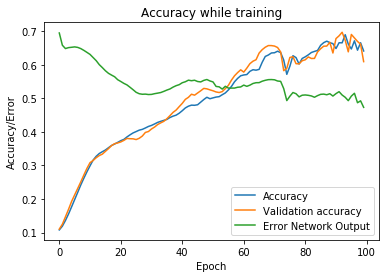

In [12]:
# plotting the training data
plt.figure()
plt.title('Accuracy while training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Error')
plt.plot(acc, label = 'Accuracy')
plt.plot(val_acc, label = 'Validation accuracy')
plt.plot(deltas, label = 'Error Network Output')
plt.legend()
plt.show()

In [13]:
# obtaining the delta network bound (TF)
for C_, v in zip(C, mean_per_neuron(x_train)):
    K.set_value(C_, v.reshape(-1, 1))
delta_network()

0.47319698

In [14]:
# obtaining weights
W = model.get_weights()[::2]
B = model.get_weights()[1::2]

In [15]:
# Creating a constant experiment
experiment = ConstantExperiment([784, 11, 12, 13, 10], [0.1, 0.2, 0.3], 1.11, W, B, 'relu')

In [16]:
# Checking that C was calculated correctly
experiment.create_max_per_layer()
experiment.update_C(x_train)
assert all([np.allclose(K.get_value(C1).flatten(), C2) for C1, C2 in zip(C, experiment.C)]), "C calculation"

In [17]:
# Calculating mean error bound (numpy)
np.mean(experiment.get_mean_error_v2())

0.47319697272590416

In [18]:
# Checking that numpy and TF implementations coincide
assert all([np.allclose(K.get_value(errors[i]).flatten(), delta) for i, delta in zip(range(0, 4), experiment.EDeltaArr)]), "Bound"